# Speed up computation with joblib.Parallel

This tutorial describes a simple parallel computing setup to speed up `shapiq` with the [joblib](https://github.com/joblib/joblib) Python package.

In [1]:
# Install the required packages
!pip install joblib

### import packages

In [2]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor

import shapiq
import joblib

{"shapiq": shapiq.__version__, "scikit-learn": sklearn.__version__, "joblib": joblib.__version__}

{'shapiq': '0.0.8', 'scikit-learn': '1.3.1', 'joblib': '1.4.2'}

### load data

In [3]:
X, y = shapiq.load_bike_sharing()
X_train, X_test, y_train, y_test = train_test_split(
    X.values, y.values, test_size=0.25, random_state=42
)
n_features = X_train.shape[1]

### train a model

In [4]:
model = MLPRegressor(hidden_layer_sizes=(128, 64), learning_rate_init=0.01, random_state=0)
model.fit(X_train, y_train)
print("Train R2: {:.4f}".format(model.score(X_train, y_train)))
print("Test  R2: {:.4f}".format(model.score(X_test, y_test)))

Train R2: 0.9660
Test  R2: 0.9454


### explain

We use `shapiq.Explainer` to explain any machine learning model for tabular data. 

It has the following basic parameters:
- `model`: The model to be explained as a callable function expecting data points as input and returning 1-dimensional predictions.
- `data`: A background dataset to be used for imputation.

In [5]:
explainer = shapiq.Explainer(model=model, data=X_train, random_state=0)

The `Explainer` class detects `TabularExplainer` as the appropriate explainer for the `MLPRegressor` model class.

In [6]:
type(explainer)

shapiq.explainer.tabular.TabularExplainer

We first explain a single prediction. A key parameter `budget` can be used to decrease approximation error at the cost of computational time.

In [7]:
x = X_test[0]
interaction_values = explainer.explain(x, budget=1024)

Let's visualize 1-order and 2-order values on a network graph.

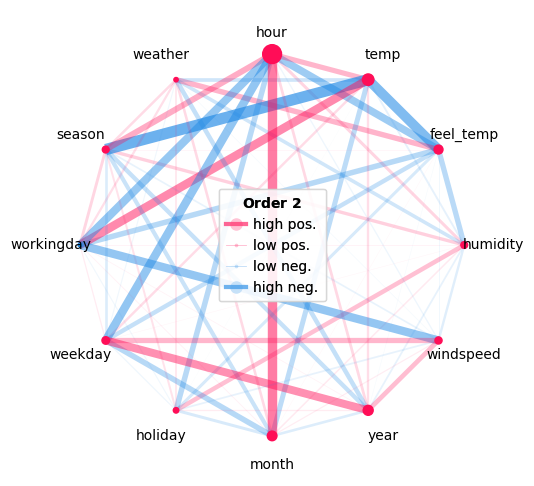

In [8]:
_ = shapiq.network_plot(
    first_order_values=interaction_values.get_n_order_values(1),
    second_order_values=interaction_values.get_n_order_values(2),
    feature_names=X.columns,
)

### longer computation = better approximation

Let's increase the precision of approximation by increasing 
1. `sample_size` (default is `100`) in the imputer used for feature marginalization, 

2. `budget` (default is `2**n_features`) used in the SHAP-IQ approximator.

In [9]:
imputer = shapiq.MarginalImputer(
    model=model.predict, data=X_train, sample_size=1024, random_state=0
)
explainer_longer = shapiq.Explainer(model=model, data=X_train, imputer=imputer, random_state=0)

In [10]:
interaction_values = explainer_longer.explain(x, budget=4096)

As expected, it took about 40x longer to compute.

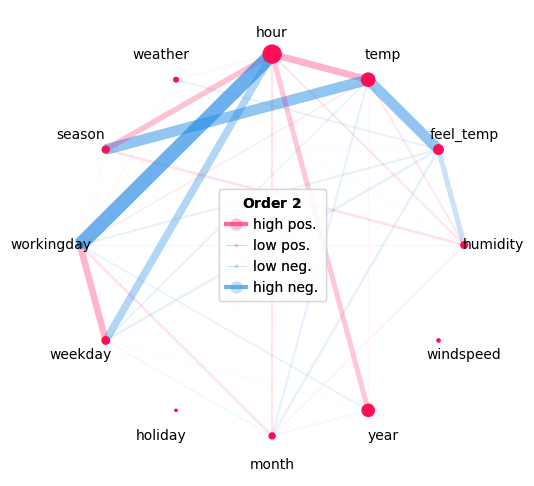

In [11]:
_ = shapiq.network_plot(
    first_order_values=interaction_values.get_n_order_values(1),
    second_order_values=interaction_values.get_n_order_values(2),
    feature_names=X.columns,
)

### compute explanations for whole test data

Our goal is to explain all 4345 instances in the test data. 

```python
ivs = []
for i in range(X_test.shape[0]):
    ivs.append(explainer_longer.explain(X_test[i, :], budget=4096))
```

Assuming that explaining a single instance takes about 5 seconds, computing explanations for whole test data will take about 6 hours (`4345*5/60/60`).

Fortunately, this can be computed in parallel using `joblib`. 

First, define the function that we want to compute in parallel.

In [12]:
def explain_instance(x):
    return explainer_longer.explain(x, budget=4096)

Then, specify the number of jobs that can run in parallel on your computing machine.

In [13]:
parallel = joblib.Parallel(n_jobs=4)

Finally, run the `explain_instance` function in parallel over multiple instances from the test data.

In [14]:
ivs = parallel(joblib.delayed(explain_instance)(X_test[i, :]) for i in range(24))

It certainly took `n_jobs=4`$\times$ less time to compute.

In [15]:
len(ivs)

24

For a comprehensive documentation of `joblib.Parallel`, refer to [Embarrassingly parallel for loops](https://joblib.readthedocs.io/en/stable/parallel.html).

### use `n_jobs` in `shapiq`

In fact, the `n_jobs` parameter is available in the `shapiq.Explainer.explain_X()` method that uses `joblib` for you.

In [16]:
ivs = explainer_longer.explain_X(X_test[:24, :], budget=4096, n_jobs=4)

In [17]:
len(ivs)

24

You can customize the `joblib` parameters by using [joblib.parallel_config()](https://joblib.readthedocs.io/en/stable/generated/joblib.parallel_config.html).

In [18]:
with joblib.parallel_config(backend="threading"):
    ivs = explainer_longer.explain_X(X_test[:8, :], budget=4096, n_jobs=4)

In [19]:
len(ivs)

8